In [1]:
import sys
sys.path.insert(0, "../..")

import jax
import jax.numpy as jnp

import jax.scipy
import jax.scipy.special

from tqdm import tqdm
from functools import partial

import module.samplers
import module.wavefunctions
import module.misc.cutoffs as cutoffs

import flax.linen as nn

import optax
import numpy as np
from matplotlib import pyplot as plt

import netket.nn.activation
import pickle

import netket as nk

from scipy.sparse.linalg import eigsh

import module.geometry.metric as metric
import module.geometry.christoffel as christoffel
import module.misc.tree_util as tree_util

/home/ewonisch/NeuralQuantumStates/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
key = jax.random.PRNGKey(1)

## Hamiltonian

$$
H = - J \sum_{<i,j>} \bigl[S_i^{(x)} S_j^{(x)} + S_i^{(y)} S_j^{(y)} +S_i^{(z)} S_j^{(z)}\bigr]
$$

In [3]:
# Define a grid
L = 16
graph = nk.graph.Hypercube(length=L, n_dim=1, pbc=True)

# The number of sites (called nodes):
print("g.n_nodes:", graph.n_nodes)
# You can iterate through the nodes:
print("g.nodes:", [node for node in graph.nodes()])
# You can check the number of edges:
print("g.n_edges:", graph.n_edges)
# You can iterate through the edges, which are stored as a 2-tuple with the start and end node:
print("g.edges:", graph.edges())

# Define the Hilbert space based on this graph
# We impose to have a fixed total magnetization of zero 
hi = nk.hilbert.Spin(s=1/2, N=graph.n_nodes, total_sz=0)

# This creates an empty operator (or zero) to which you can add others.
J = -1.
hamiltonian = nk.operator.LocalOperator(hi)

# interactions
for (i,j) in graph.edges():
    hamiltonian = hamiltonian - J * nk.operator.spin.sigmax(hi, i) @ nk.operator.spin.sigmax(hi, j)
    hamiltonian = hamiltonian - J * nk.operator.spin.sigmay(hi, i) @ nk.operator.spin.sigmay(hi, j)
    hamiltonian = hamiltonian - J * nk.operator.spin.sigmaz(hi, i) @ nk.operator.spin.sigmaz(hi, j)


hamiltonian_jax = hamiltonian.to_pauli_strings().to_jax_operator()
all_states = jnp.array([state for state in hi.states()])

g.n_nodes: 16
g.nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
g.n_edges: 16
g.edges: [(0, 1), (9, 10), (13, 14), (1, 2), (10, 11), (3, 4), (12, 13), (2, 3), (6, 7), (4, 5), (8, 9), (0, 15), (5, 6), (11, 12), (14, 15), (7, 8)]


In [4]:
ha = hamiltonian.to_sparse()
e_gs, psi_gs = eigsh(ha, k=1, which = "SA")
E_f = e_gs[0]
psi_gs = psi_gs.reshape(-1)
print("E_f = ", E_f)

E_f =  -28.569185442467138


In [5]:
def calc_H_loc(orbital, parameters, samples):
    eta, H_sigmaeta = hamiltonian_jax.get_conn_padded(samples)
    
    logpsi_sigma = orbital.calc_logpsi(parameters, samples)
    logpsi_eta = orbital.calc_logpsi(parameters, eta)
    logpsi_sigma = jnp.expand_dims(logpsi_sigma, -1) 
    
    res = jnp.sum(H_sigmaeta * jnp.exp(logpsi_eta - logpsi_sigma), axis=-1)
    
    return res

## Construct Neural Network

In [6]:
def act(x):
    return netket.nn.activation.log_cosh(x)

In [7]:
class NN(nn.Module):
    """
    Constructs a neural network.

    possible activation functions:
    netket.nn.activation.log_cosh(x)
    nn.softplus()
    """
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(16*3, name="dense1", param_dtype="float64", bias_init=jax.nn.initializers.normal(stddev=0.1))(x)
        x = act(x)
        x = nn.Dense(2, name="dense2", param_dtype="float64", use_bias=False)(x)

        return jnp.squeeze(x)

## Construct Ansatz

In [8]:
class Ansatz(module.wavefunctions.Wavefunction):
    def __init__(self):
        super().__init__(input_shape = (graph.n_nodes,))

        self.nn = NN()
        # self.phase = NN()
        self.unravel = None


    def init_param(self, key):
        nn_param = self.nn.init(key, jnp.empty((graph.n_nodes,)))
        # key, _ = jax.random.split(key)
        # phase_param = self.nn.init(key, jnp.empty((graph.n_nodes,)))

        # param =  {"nn": nn_param, "phase": phase_param}
        param = {"nn":nn_param}
        flat_param, unravel = jax.flatten_util.ravel_pytree(param)
        self.unravel = unravel
        return flat_param
    

    @partial(jax.jit, static_argnames=['self'])
    def shift_samples(self, samples):
        repeated = jnp.repeat(jnp.expand_dims(samples, axis = 0), g.n_nodes, axis = 0)
        shifted = jax.lax.scan(self.f, 0, repeated)[1]
        return shifted

    def f(self, state, slice):
        out = jnp.roll(slice, state, axis = -1)
        return state + 1, out
    
    def calc_logpsi(self, parameters, x):
        param = self.unravel(parameters)
       
        # shifted = self.shift_samples(x)
        # log_psi = self.nn.apply(parameters["nn"], shifted)
        # sym = jnp.sum(log_psi, axis = 0)

        a = self.nn.apply(param["nn"], x)
        return a[...,0]+1.j*a[...,1]

In [9]:
ansatz = Ansatz()
key, _ = jax.random.split(key)
param = ansatz.init_param(key)

## Sampler

In [10]:
class SpinSwapSampler(module.samplers.MCMC):
    def propose(self, key, element):
        subkey, _ = jax.random.split(key)

        index = jax.random.randint(subkey, (), 0, graph.n_nodes)
        neigh = (index + 1)
        h = jnp.copy(element[neigh])

        proposal = element.at[neigh].set(element[index])
        proposal = proposal.at[index].set(h)

        return subkey, proposal
def init_chain():
    init = jnp.ones((graph.n_nodes))
    choice = jax.random.choice(key, graph.n_nodes, (int(graph.n_nodes/2),), replace=False)
    return init.at[choice].mul(-1)

    
sampler = SpinSwapSampler(ansatz, 1)
subsampling = graph.n_nodes

def get_samples(N):
    """
    Returns decorrelated samples.
    """
    samples, ratio = sampler.sample(key, param, init_chain() , N*subsampling)
    return samples[0:-1:subsampling], ratio

## Optimisation

In [11]:
@partial(jax.jit, static_argnames=['orbital'])
def calc_grad_E(orbital, parameters, samples):
    """
    Calculates the gradient of the energy and the energy itself on a batch of samples.
    """

    E_loc = calc_H_loc(orbital, parameters, samples)
    E = jnp.mean(E_loc.real)
    dE = jnp.std(E_loc.real)

    logpsi_red = lambda parameters: jnp.conjugate(orbital.calc_logpsi(parameters, samples))
    y, v = netket.jax.vjp(logpsi_red, parameters)
    N = samples.shape[0]

    m = lambda tree: 2*jnp.real(tree/N)

    return jax.tree_util.tree_map(m, v(E_loc - E))[0], E, dE

In [12]:
def calc_norm_square(ansatz, samples, primals, tangent):
    g = lambda v: jax.tree_util.tree_reduce(lambda c,d : c + d, jax.tree_util.tree_map(lambda a: jnp.sum(a), v))
    return  g(jax.tree_util.tree_map(lambda c, d : c * d, tangent, metric.apply_g(ansatz, samples, primals, tangent)))

## Optimisation

In [13]:
stats = {"E":[], "dE":[], "ratio":[], "N_samples": [], "rel_err":[], "param":[], "gradient": [], "correction":[], "inv_g":[], "g":[]}
key, _ = jax.random.split(key)
param = ansatz.init_param(key)

In [14]:
N = 1500
epoch = 100

lr = 0.009
beta = 0.
diag = 0.01

## initialise parameters
samples = get_samples(N)[0]
grad, E, dE = calc_grad_E(ansatz, param, samples)
g = metric.get_g(ansatz, samples, param, diag)
initial_gradient = jnp.linalg.pinv(g) @ grad
old_param = param + lr/(1 - beta) * initial_gradient

2024-06-05 15:54:32.160537: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %pad.11 = f64[912,1500,2]{2,1,0} pad(f64[912,1500,1]{2,1,0} %broadcast.59, f64[] %constant.26), padding=0_0x0_0x0_1, metadata={op_name="jit(get_g)/jit(main)/vmap(jit(apply_g))/pad[padding_config=((0, 0, 0), (0, 0, 0), (0, 1, 0))]" source_file="/tmp/ipykernel_70707/1876301801.py" source_line=40}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-06-05 15:54:43.579063: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 12.418663009s
Constant folding an instruction is taking > 1s:

  %

In [18]:
hamiltonian_jax = hamiltonian.to_pauli_strings().to_jax_operator()

for i in tqdm(range(epoch)):
    key, _ = jax.random.split(key)

    # samples
    samples, ratio = get_samples(N)

    # old update
    delta_param = param - old_param


    # geodesic correction
    cor = christoffel.geodesic_correction(ansatz, samples, param, delta_param)

    # compute inversde metric
    g = metric.get_g(ansatz, samples, param, eps = 0)
    inv_g = jnp.linalg.pinv(g, hermitian=True, rcond=1e-4)

    #
    # parallel transport old momentum and damp
    #
    trans = beta * (delta_param - inv_g @ cor)

    #
    # nesterov gradient
    #
    # gradient
    grad, E, dE = calc_grad_E(ansatz, param + trans, samples)
    nat_grad = inv_g @ grad

    # update
    new_param = param + trans - lr * nat_grad
    old_param = param
    param = new_param

    if jnp.any(jnp.isnan(param)):
        raise Exception("The optimisation scheme has diverged.")
    
    # store statistics
    stats["E"].append(E)
    stats["dE"].append(dE)
    stats["ratio"].append(ratio)
    stats["N_samples"].append(N)
    stats["rel_err"].append(jnp.abs(E - E_f)/-E_f)
    stats["param"].append(jnp.copy(param))
    stats["gradient"].append(grad)
    stats["correction"].append(cor)
    stats["inv_g"].append(inv_g)
    stats["g"].append(g)

100%|██████████| 100/100 [01:58<00:00,  1.19s/it]


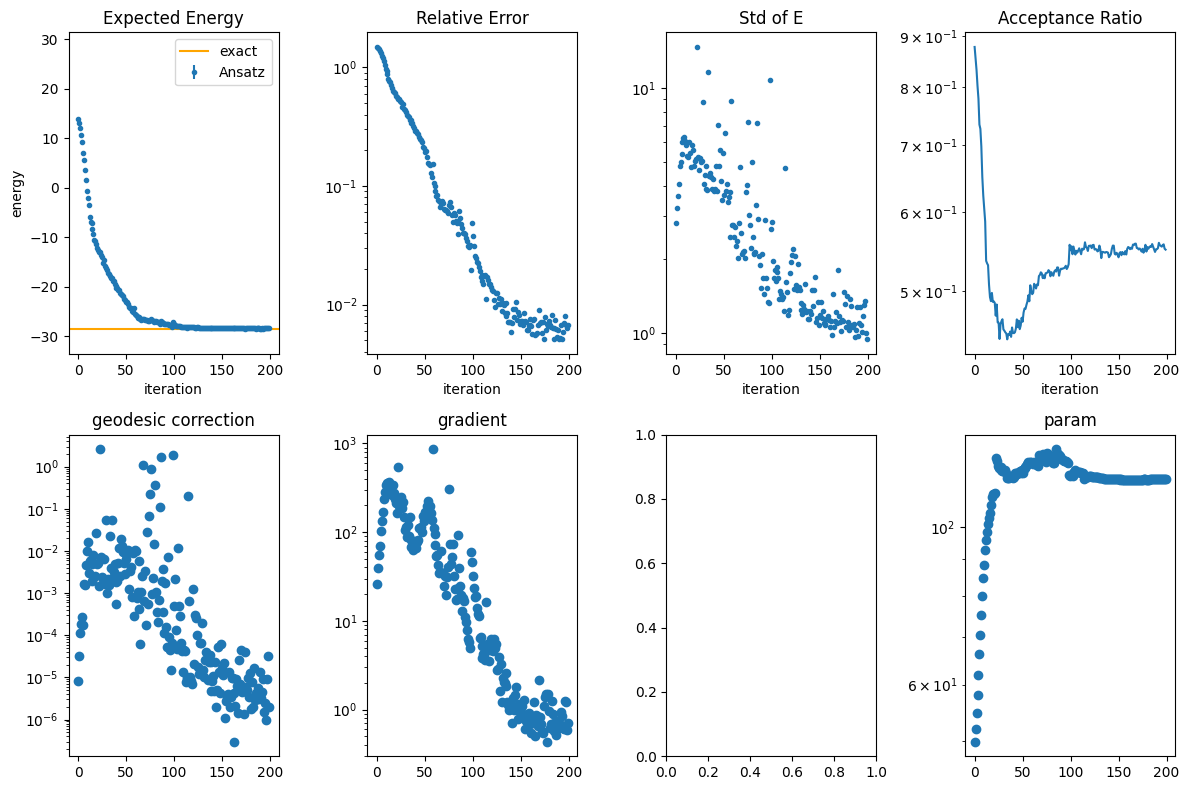

In [19]:
numpy_stats = {}
for key_ in stats.keys():
    numpy_stats[key_] = np.array(stats[key_])

f, ax = plt.subplots(2, 4, figsize = (12, 8))
i = np.arange(len(stats["E"]))

ax[0,0].errorbar(i, numpy_stats["E"], yerr = numpy_stats["dE"]/jnp.sqrt(numpy_stats["N_samples"]), fmt = ".", label = "Ansatz")
ax[0,0].set_title("Expected Energy")
ax[0,0].axhline(E_f, label = "exact", color = "orange")
ax[0,0].legend(loc = "upper right")
ax[0,0].set_ylim(E_f-5, E_f+60)
ax[0,0].set_xlabel("iteration")
ax[0,0].set_ylabel("energy")


ax[0,1].scatter(i, jnp.abs(numpy_stats["E"]-E_f)/-E_f , label = "error", marker = ".")
ax[0,1].set_title("Relative Error")
ax[0,1].set_yscale("log")
# ax[1].set_xscale("log")
ax[0,1].set_xlabel("iteration")

ax[0,2].scatter(i, stats["dE"], marker = ".")
ax[0,2].set_title("Std of E")
ax[0,2].set_yscale("log")
ax[0,2].set_xlabel("iteration")

ax[0,3].plot(stats["ratio"])
# ax[3].set_ylim(0,1)
ax[0,3].set_title("Acceptance Ratio")
ax[0,3].set_xlabel("iteration")
ax[0,3].set_yscale("log")

ax[1,0].scatter(i, jnp.sum(numpy_stats["correction"]**2, axis = -1))
ax[1,0].set_title("geodesic correction")
ax[1,0].set_yscale("log")

ax[1,1].scatter(i, jnp.sum(numpy_stats["gradient"]**2, axis = -1))
ax[1,1].set_title("gradient")
ax[1,1].set_yscale("log")

# ax[1,2].scatter(i, numpy_stats["inv_g"])
# ax[1,2].set_title("det inv g")
# ax[1,2].set_yscale("log")

ax[1,3].scatter(i, jnp.sum(numpy_stats["param"]**2, axis = -1))
ax[1,3].set_title("param")
ax[1,3].set_yscale("log")



f.tight_layout()

In [20]:
param = numpy_stats["param"][-1]
samples, _ = get_samples(1500)
g = metric.get_g(ansatz, samples, param, eps = 0)

In [35]:
inv_g = jnp.linalg.pinv(g, hermitian=True, rcond=1e-4)

In [36]:
U, S, Vh = jnp.linalg.svd(g)
U, inv_S, Vh = jnp.linalg.svd(inv_g)

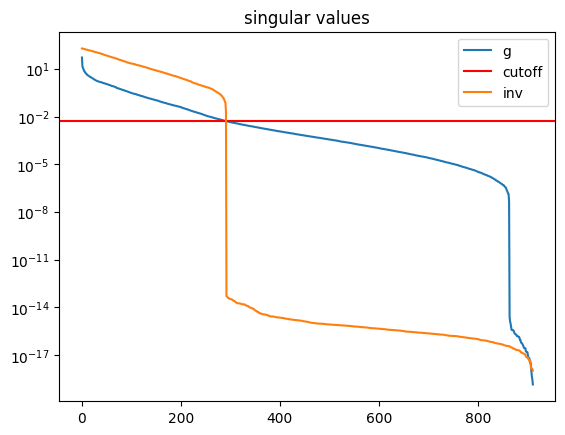

In [37]:
plt.plot(S, label = "g")
plt.axhline(jnp.max(S)*1e-4, color = "red", label = "cutoff")
plt.plot(inv_S, label = "inv")
plt.yscale("log")
plt.title("singular values")
plt.legend()

In [ ]:
plt.imshow(jnp.isclose(g @ inv_g, 0))
plt.colorbar()

In [ ]:
plt.imshow(jnp.log(jnp.abs(g)))
plt.colorbar()

In [ ]:
N = 30000
key, _ = jax.random.split(key)
samples, ratio = get_samples(N)
hamiltonian_jax = hamiltonian.to_pauli_strings().to_jax_operator()
H_loc = calc_H_loc(ansatz, param, samples).real
print("Acceptance Ratio:\t", ratio)
print("Expected Energy:\t\t", jnp.mean(H_loc),"+/-", jnp.std(H_loc)/jnp.sqrt(N))
print("Ground Truth:\t\t\t", E_f)
print("Energy Error:\t\t", (jnp.mean(H_loc) - E_f)/jnp.abs(E_f))
print("Std of Expected Energy:\t", jnp.std(H_loc))

In [38]:
psi = ansatz.calc_psi(param, all_states)

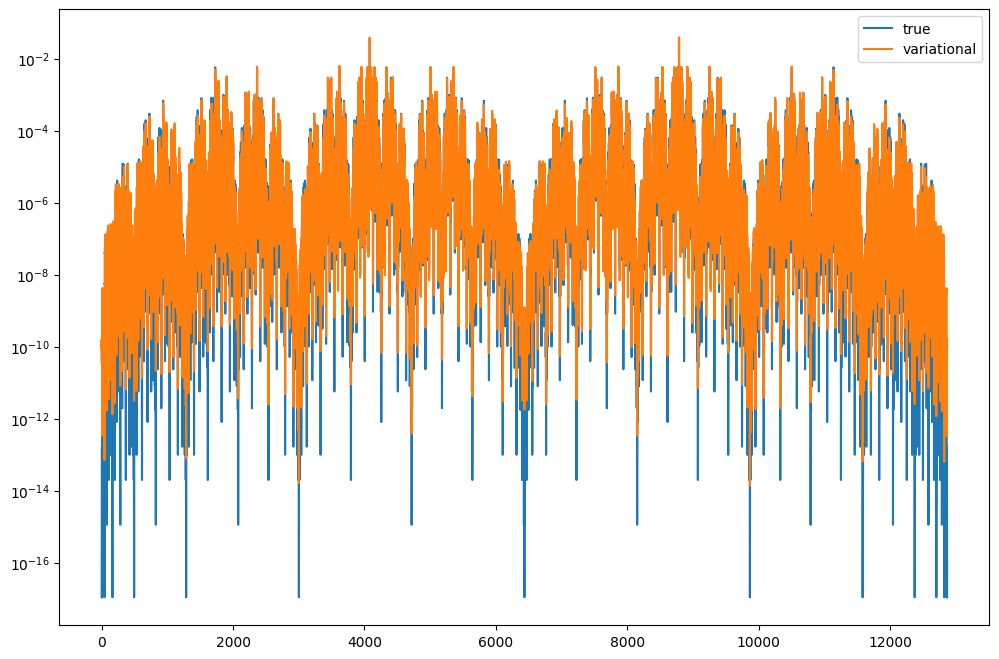

In [41]:
plt.figure(figsize=(12,8))
plt.plot(jnp.abs(psi_gs)**2/jnp.sum(jnp.abs(psi_gs)**2), label="true")
plt.plot(jnp.abs(psi)**2/jnp.sum(jnp.abs(psi)**2), label = "variational")


plt.yscale("log")
# plt.xlim(0,1000)
plt.legend()

---